### data preprocessing


dataset : https://finance.yahoo.com/quote/sbux/history/

In [26]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn. model_selection import train_test_split

In [27]:
data = pd.read_csv('./data/SBUX.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
1,2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2,2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
3,2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
4,2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       253 non-null    object 
 1   Open       253 non-null    float64
 2   High       253 non-null    float64
 3   Low        253 non-null    float64
 4   Close      253 non-null    float64
 5   Adj Close  253 non-null    float64
 6   Volume     253 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


In [29]:
data.sort_values('Date', inplace=True)

In [30]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


In [31]:
data['Volume'] = data['Volume'].astype(float)

In [32]:
X = data.drop('Volume', axis=1)
y = data[['Volume']]

In [33]:
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [34]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Train', X_train.shape, X_test.shape)
print('Test', y_train.shape, y_test.shape)

Train (200, 5) (53, 5)
Test (200, 1) (53, 1)


In [35]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Train', X_train_tensors_f.shape, X_test_tensors_f.shape)
print('Test', y_train.shape, y_test.shape)

Train torch.Size([200, 1, 5]) torch.Size([53, 1, 5])
Test (200, 1) (53, 1)


### model

In [36]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

### train

In [37]:
num_epochs = 10000
lr = 0.0001
input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes=num_classes, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, seq_length=X_train_tensors_f.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

LSTM(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [38]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    acc = (preds == y_train_tensors).sum() / X_train_tensors_f.shape[0]

    if epoch % 100 == 0:
        print(f' Epoch {epoch}/{num_epochs} : \tAcc : {acc}, Loss : {loss.item():.6f}')

 Epoch 0/10000 : 	Acc : 1.0, Loss : 0.237095
 Epoch 100/10000 : 	Acc : 1.0, Loss : 0.081408
 Epoch 200/10000 : 	Acc : 1.0, Loss : 0.044999
 Epoch 300/10000 : 	Acc : 1.0, Loss : 0.040422
 Epoch 400/10000 : 	Acc : 1.0, Loss : 0.039722
 Epoch 500/10000 : 	Acc : 1.0, Loss : 0.039453
 Epoch 600/10000 : 	Acc : 1.0, Loss : 0.039314
 Epoch 700/10000 : 	Acc : 1.0, Loss : 0.039235
 Epoch 800/10000 : 	Acc : 1.0, Loss : 0.039182
 Epoch 900/10000 : 	Acc : 1.0, Loss : 0.039126
 Epoch 1000/10000 : 	Acc : 1.0, Loss : 0.039027
 Epoch 1100/10000 : 	Acc : 1.0, Loss : 0.038787
 Epoch 1200/10000 : 	Acc : 1.0, Loss : 0.038206
 Epoch 1300/10000 : 	Acc : 1.0, Loss : 0.036996
 Epoch 1400/10000 : 	Acc : 1.0, Loss : 0.035263
 Epoch 1500/10000 : 	Acc : 1.0, Loss : 0.033651
 Epoch 1600/10000 : 	Acc : 1.0, Loss : 0.032603
 Epoch 1700/10000 : 	Acc : 1.0, Loss : 0.032077
 Epoch 1800/10000 : 	Acc : 1.0, Loss : 0.031728
 Epoch 1900/10000 : 	Acc : 1.0, Loss : 0.030964
 Epoch 2000/10000 : 	Acc : 1.0, Loss : 0.028733
 Epo

In [39]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))

df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

In [40]:
df_x_ss

tensor([[[0.4650, 0.4364, 0.5154, 0.4961, 0.3955]],

        [[0.6539, 0.6627, 0.6904, 0.6712, 0.5653]],

        [[0.6561, 0.6515, 0.6945, 0.7209, 0.6136]],

        ...,

        [[1.9970, 2.0828, 1.9814, 2.0760, 2.1469]],

        [[2.1675, 2.1545, 1.9907, 1.9885, 2.0602]],

        [[2.3380, 2.5890, 2.2651, 2.5277, 2.5941]]])

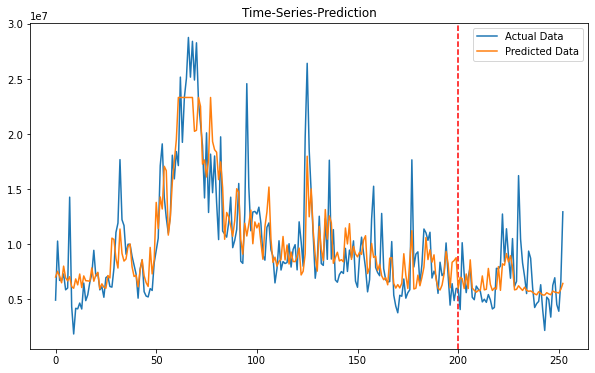

In [41]:
train_predict = model(df_x_ss)
pred = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

pred = ms.inverse_transform(pred)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')
plt.plot(label_y, label='Actual Data')
plt.plot(pred, label='Predicted Data')
plt.title('Time-Series-Prediction')
plt.legend()
plt.show()